In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import joblib
import math
import ast
import logging
from pathlib import Path  
from msig import Motif, NullModel

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load YAML configuration
config_path = "config.yaml" 
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

BASE_DIR = Path(config["base_dir"]).resolve()

RESULTS_DIR = BASE_DIR / config["results_dir"]
IMAGES_DIR = BASE_DIR / config["images_dir"]
DATA_DIR = BASE_DIR / config["data_dir"]
DATASET_PATH = BASE_DIR / config["dataset_path"]
RESULTS_MOTIF_DIR = BASE_DIR / config["results_motif_dir"]

VARIABLES = config["variables"]
NORMALIZE_FLAGS = config["normalize_flags"]
STUMPY_EXCL_ZONE_DENOM = config["stumpy_excl_zone_denom"]
TOP_K_MP = config["top_k_mp"]
INCLUDE = config["include"]
NORMALIZE = config["normalize"]
SUBSEQUENCES_LENGTHS = config["subsequences_lengths"]
NTOP_MOTIFS = config["ntop_motifs"]
MOTIF_SIZE = config["motif_size"]
LOOKBACK_PERIOD = config["lookback_period"]
STEP = config["step"]
FORECAST_PERIOD = config["forecast_period"]

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")
print(f"Dataset path: {DATASET_PATH}")

if '__file__' in globals():
    # For standalone scripts
    base_dir = Path(__file__).parent.resolve()
else:
    # For Jupyter or interactive environments
    base_dir = Path(os.getcwd()).resolve()

sys.path.append(str(base_dir / "../"))


Results will be saved in: /home/mgsilva/motifpred/results/refit
Images will be saved in: /home/mgsilva/motifpred/images/refit
Data will be accessed from: /home/mgsilva/motifpred/data/refit
Dataset path: /home/mgsilva/motifpred/data/refit/data_1maveraged_3weeks.csv


In [2]:
mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table
mp_stats_table = mp_stats_table[mp_stats_table["m"] == MOTIF_SIZE]
top_motifs = mp_stats_table.sort_values(by=["#Matches", "ID"], ascending=[False, True]).head(NTOP_MOTIFS)
top_motifs = top_motifs[["m", "Indices", "Features"]]


In [3]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [4]:
#load data as 
data_df = pd.read_csv(DATASET_PATH, index_col=0).astype(float)
data_df = data_df[VARIABLES]
data = data_df.values.T
data

array([[ 1.875,  1.9  , 40.   , ...,  2.   ,  2.   ,  2.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [5]:
# Set global style for scientific plots
plt.rcParams.update({
    "font.family": "serif",  # Use a serif font for better readability in papers
    "font.size": 14,         # Increase font size for clarity
    "axes.titlesize": 16,    # Larger title font size
    "axes.labelsize": 14,    # Axis label size
    "xtick.labelsize": 12,   # Tick size for x-axis
    "ytick.labelsize": 12,   # Tick size for y-axis
    "legend.fontsize": 12,   # Legend font size
    "figure.figsize": (6, 4) # Standard paper figure size
})


for i, row in top_motifs.iterrows():
    motif_indices = sorted(ast.literal_eval(row["Indices"]))
    features = sorted(ast.literal_eval(row["Features"]))
    print(features)
    num_vars = len(features)

    # Create subplots for each variable
    fig, axs = plt.subplots(num_vars, 2, figsize=(8, 3 * num_vars), dpi=300, gridspec_kw={'width_ratios': [1, 2]},  constrained_layout=True)

    if num_vars == 1:
        axs = np.expand_dims(axs, axis=0)  # Ensure it remains iterable for a single-variable case

    for var_idx in range(num_vars): 
        motif_subsequences = []

        # Extract motif sequences for the current variable
        for indice in motif_indices:
            feature = features[var_idx]
            seq = data[feature, indice:indice + MOTIF_SIZE]
            if len(seq) == MOTIF_SIZE:  # Ensure valid motif length
                norm_seq = seq
                motif_subsequences.append(norm_seq)

        if not motif_subsequences:
            print(f"Skipping motif {i} for variable {feature} due to empty subsequences.")
            continue

        motif_subsequences = np.array(motif_subsequences)

        # Plot normalized motif subsequences
        axs[var_idx, 0].plot(motif_subsequences.T, color="black", alpha=0.3, linewidth=1)
        axs[var_idx, 0].set_title(f"Normalized Subsequences", fontsize=16)
        axs[var_idx, 0].set_xlabel("Time", fontsize=14)
        axs[var_idx, 0].grid(True, linestyle="--", alpha=0.5)

        # Plot original time series with motif locations
        axs[var_idx, 1].plot(data[feature, : ], color="black", alpha=0.7, linewidth=1.5)
        for indice in motif_indices:
            axs[var_idx, 1].axvline(x=indice, color="red", linestyle="--", linewidth=1.2, alpha=0.5, 
                                    label="Motif Occurrence" if indice == motif_indices[0] else "")
        axs[var_idx, 1].set_title(f" Time Series ({VARIABLES[feature]})", fontsize=16)
        axs[var_idx, 1].set_xlabel("Time", fontsize=14)
        axs[var_idx, 1].grid(True, linestyle="--", alpha=0.5)

        # Add legend only once
        if len(motif_indices) > 0:
            axs[var_idx, 1].legend(loc="upper right", frameon=True)

    # Save as high-quality PNG or PDF
    plt.savefig(IMAGES_DIR / f"top_motif_{i}.png", dpi=300, bbox_inches="tight")
    plt.savefig(IMAGES_DIR / f"top_motif_{i}.pdf", bbox_inches="tight")  # Optional PDF for papers
    plt.close()


[7, 8]
[1, 6]
[7, 8]


In [6]:
# from utils.utils import create_dataset
# from utils.train_pipeline import run_optuna_study
# from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
# from models.lstm_pytorch import LSTM
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config_train_val_test


# test_losses_list = []
# test_mae_list = []
# test_rmse_list = []

# # Loop through each of the top 10 motifs
# for i, top_motif in top_motifs.iterrows():
#     motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
#     print(f"Evaluating motif {i+1} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")
    
#     # Create dataset for the current motif
#     X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

#     # X_series, X2, and y are now PyTorch tensors
#     print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
#     print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
#     print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
#     print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
#     # Define the model and run the Optuna study
#     n_trials = 100
#     num_epochs = 500
#     model_type = "LSTM"
#     model_name = "LSTMSeries"

#     suggestion_dict = {
#         "learning_rate": {
#             "type": "float",
#             "args": [1e-5, 1e-3], 
#             "kwargs": {"log": True} 
#         },
#         "num_layers": {
#             "type": "categorical",
#             "args": [[1,3,5]]  
#         },
#         "batch_size": {
#             "type": "categorical",
#             "args": [[16, 32, 64, 128]]
#         }
#     }

#     model_params_keys = ["hidden_sizes_list"]
#     model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
#     os.makedirs(model_results_dir, exist_ok=True)  

#     X = {"X_series": X_series}
#     #run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

#     study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
#     train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

#     print(f"Best epoch: {best_epoch}")
#     print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

#     test_losses_list.append(test_loss)
#     test_mae_list.append(test_mae)
#     test_rmse_list.append(test_rmse)
    
#     # Plot predictions vs true values
#     #epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
#     #plot_best_model_results_traindevtest( study.trials_dataframe(),
#     #    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
#     #)    
#     #plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# # Convert lists to numpy arrays for easier calculations
# test_losses_array = np.array(test_losses_list)
# test_mae_array = np.array(test_mae_list)
# test_rmse_array = np.array(test_rmse_list)

# # Calculate mean and standard deviation
# mean_test_loss = np.mean(test_losses_array)
# std_test_loss = np.std(test_losses_array)

# mean_test_mae = np.mean(test_mae_array)
# std_test_mae = np.std(test_mae_array)

# mean_test_rmse = np.mean(test_rmse_array)
# std_test_rmse = np.std(test_rmse_array)

# # Print aggregated results
# print(f"Aggregated Results Across Top 5 Motifs:")
# print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
# print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
# print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 13 with size 48 and 205 indexes 
X_series shape: torch.Size([2881, 864, 2])
X_indices shape: torch.Size([2881, 17, 1])
X_mask shape: torch.Size([2881, 864])
y shape: torch.Size([2881, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 71, with best epoch being 60
Early stopping at epoch 442, with best epoch being 431
Early stopping at epoch 337, with best epoch being 326
Early stopping at epoch 146, with best epoch being 135
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 26, with best epoch being 15
Early stopping at epoch 27, with best epoch being 16
Early stopping at epoch 26, with best epoch being 15
Early stopping at epoch 26, with best epoch being 15
Early stopping at epoch 48, with best epoch being 37
Early stopping at epoch 37, with best epoch being 26
Early stopping at epoch 48, with best epoch being 37
Early stopping at epoch 48, with best epoch being 37
Early stopping at epoch 27, with best epoch being 16
Early

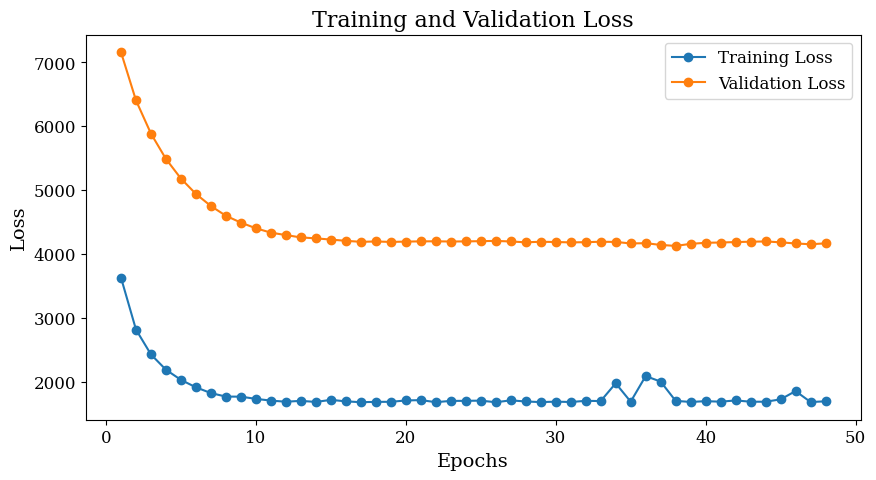

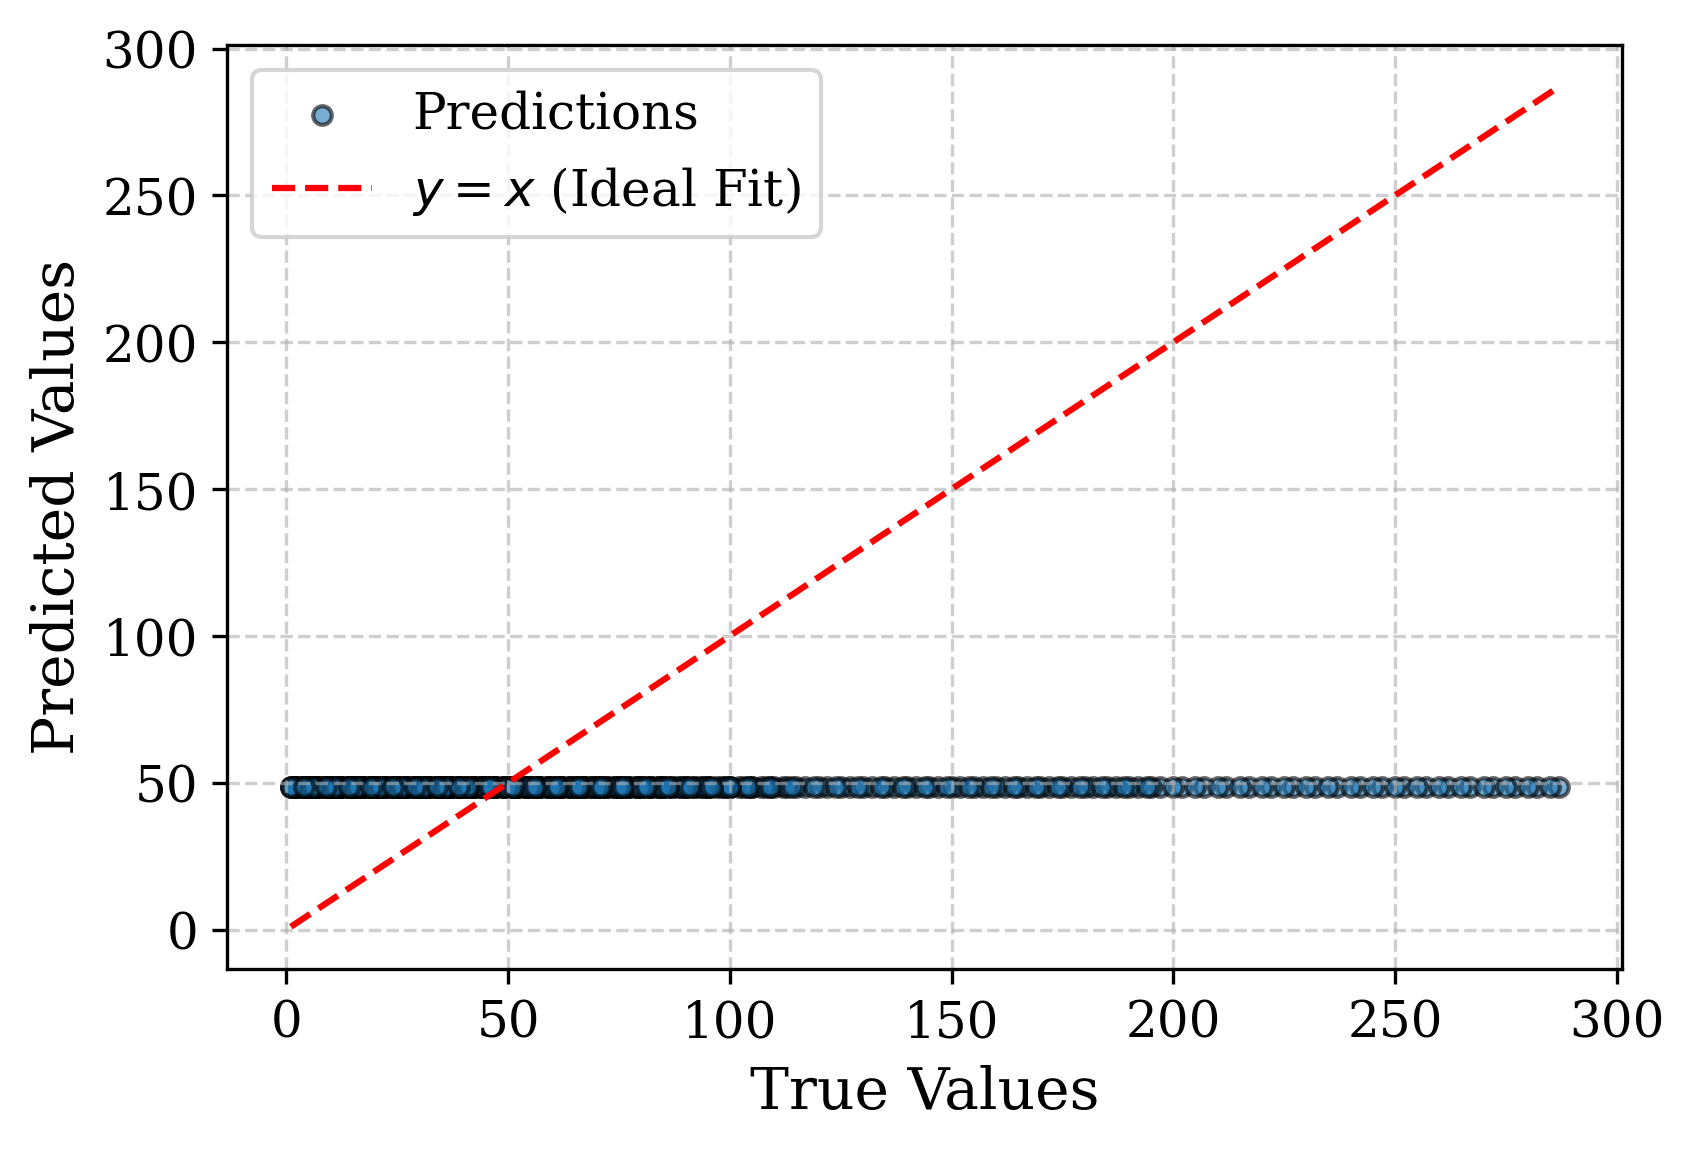

Evaluating motif 11 with size 48 and 202 indexes 
X_series shape: torch.Size([2927, 864, 2])
X_indices shape: torch.Size([2927, 17, 1])
X_mask shape: torch.Size([2927, 864])
y shape: torch.Size([2927, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 75, with best epoch being 63
Stopping early: Maximum training time exceeded.
Early stopping at epoch 460, with best epoch being 456
Early stopping at epoch 374, with best epoch being 361
Early stopping at epoch 276, with best epoch being 265
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 165, with best epoch being 154
Early stopping at epoch 126, with best epoch being 115
Early stopping at epoch 134, with best epoch being 123
Early stopping at epoch 182, with best epoch being 171
Early stopping at epoch 289, with best epoch being 278
Early stopping at epoch 94, with best epoch being 83
Early stopping at epoch 305, with best epoch being 294
Early stopping at epoch 260, with best epoch being 

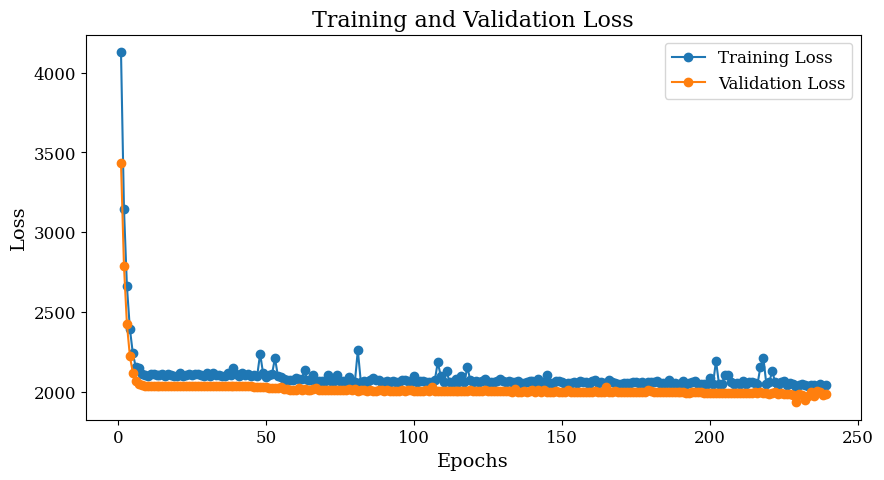

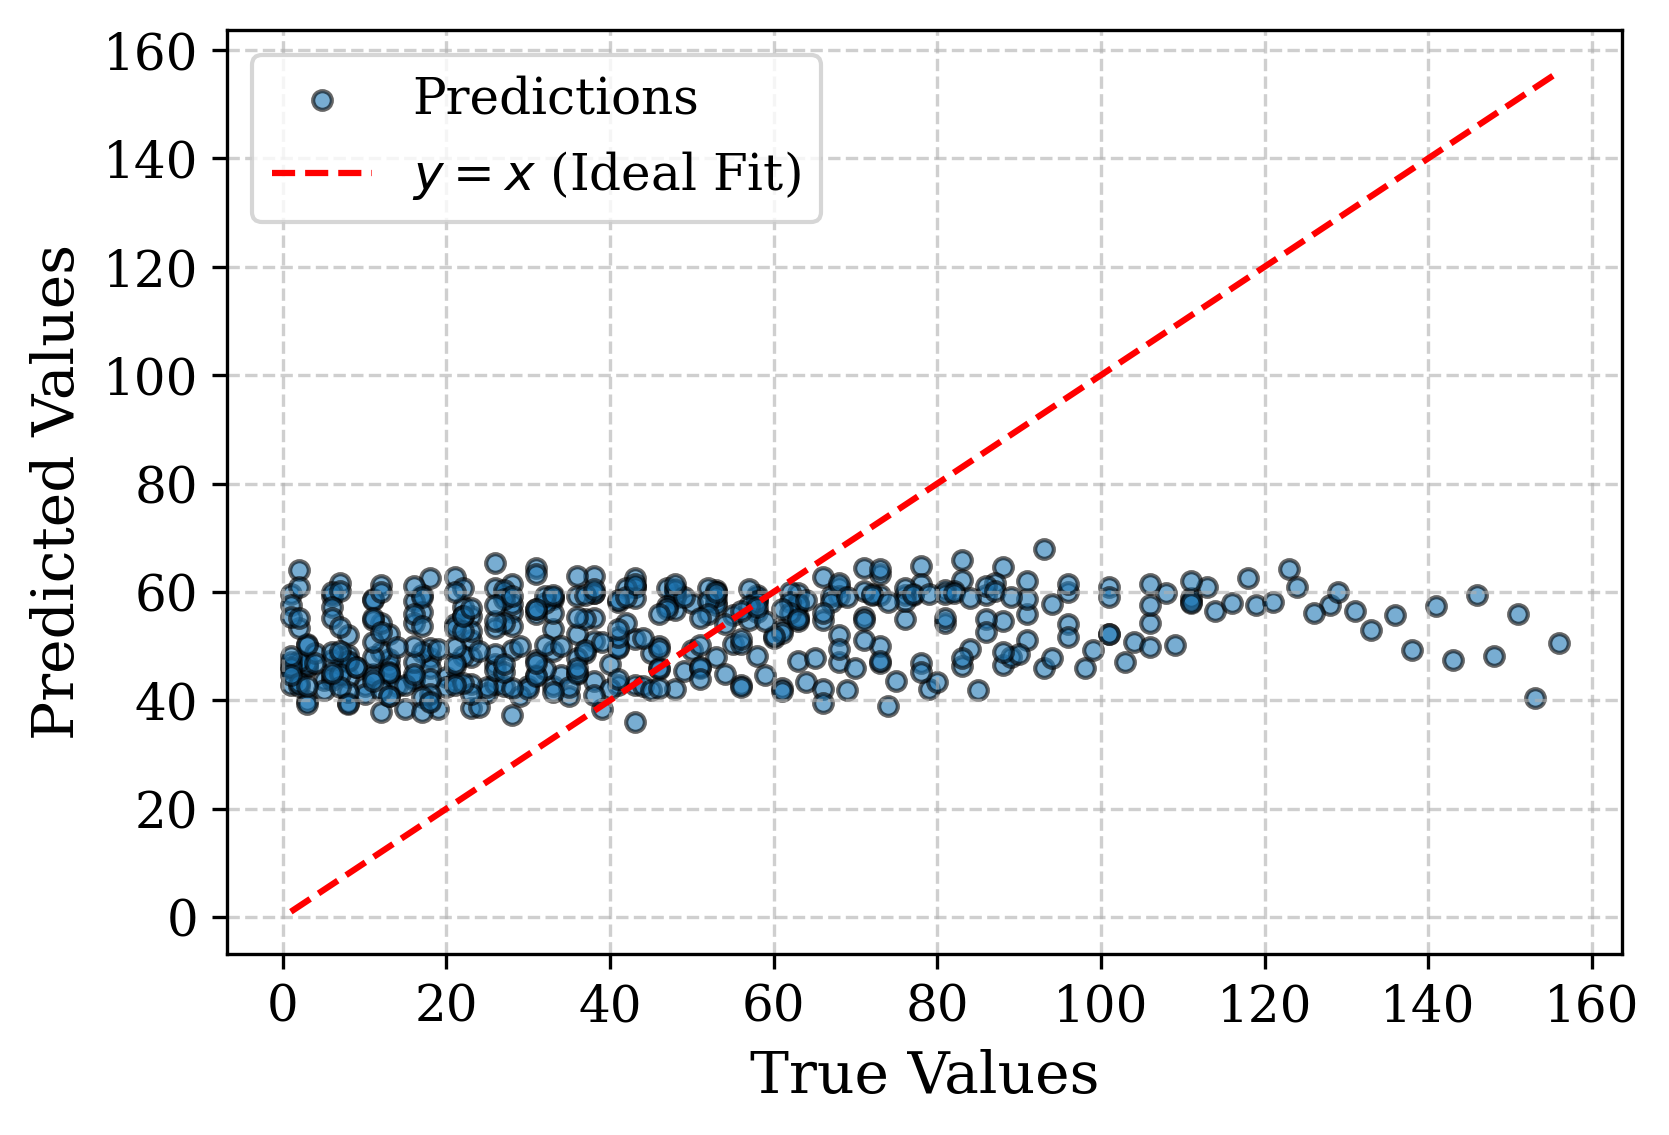

Evaluating motif 14 with size 48 and 167 indexes 
X_series shape: torch.Size([2910, 864, 2])
X_indices shape: torch.Size([2910, 15, 1])
X_mask shape: torch.Size([2910, 864])
y shape: torch.Size([2910, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 50, with best epoch being 39
Early stopping at epoch 333, with best epoch being 322
Early stopping at epoch 243, with best epoch being 232
Early stopping at epoch 216, with best epoch being 205
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 58, with best epoch being 47
Early stopping at epoch 48, with best epoch being 37
Early stopping at epoch 46, with best epoch being 35
Early stopping at epoch 123, with best epoch being 112
Early stopping at epoch 21, with best epoch being 10
Early stopping at epoch 247, with best epoch being 236
Early stopping at epoch 152, with best epoch being 141
Early stopping at epoch 170, with best epoch being 159
Early stopping at epoch 14, with best epoch being 

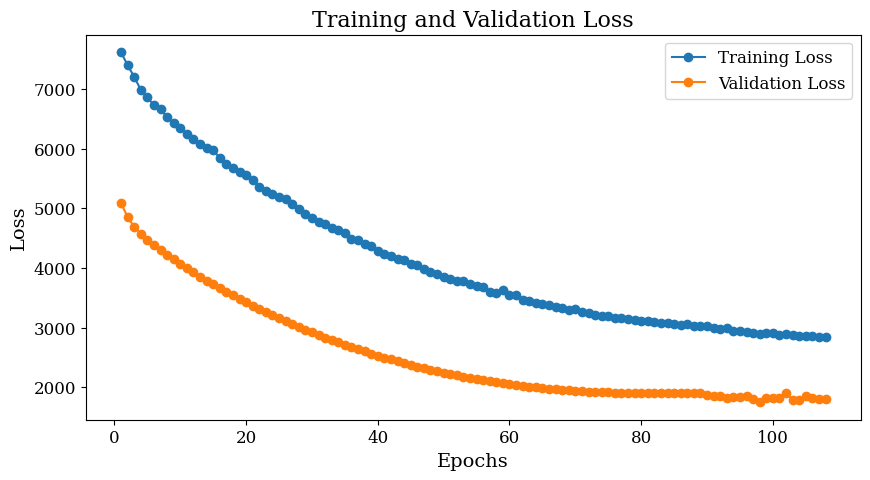

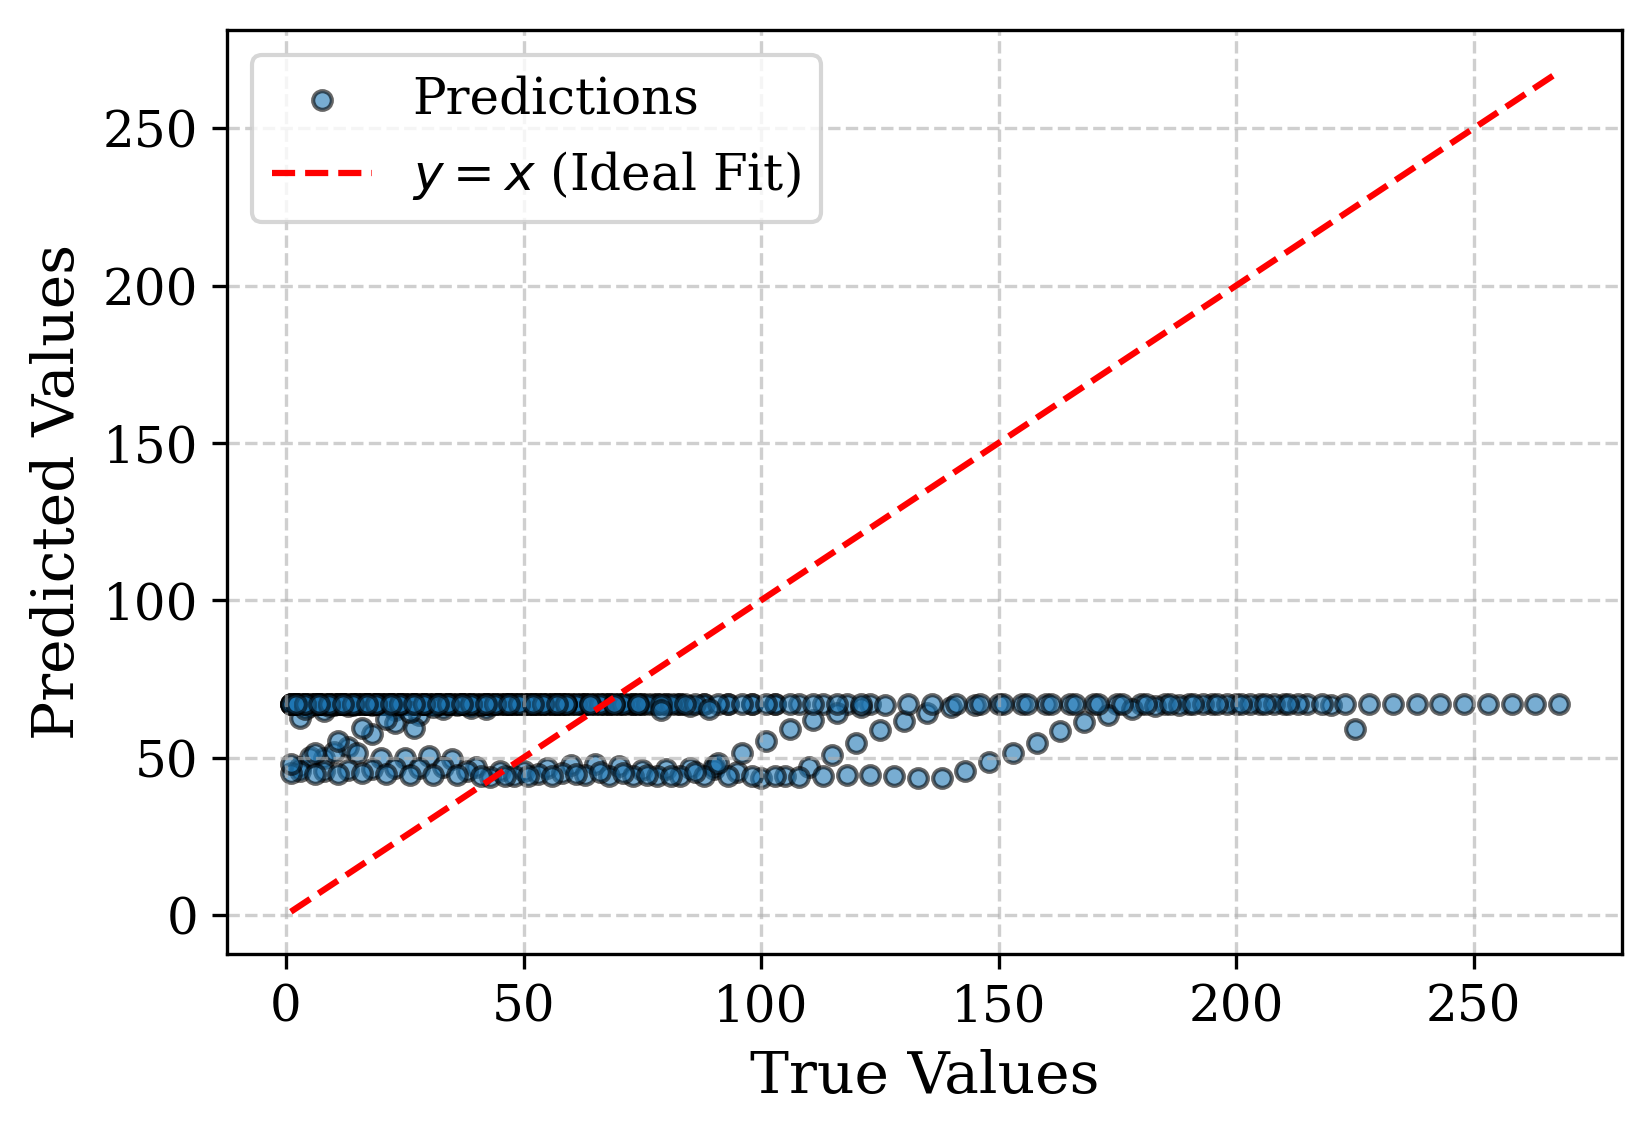

Evaluating motif 12 with size 48 and 157 indexes 
X_series shape: torch.Size([2884, 864, 2])
X_indices shape: torch.Size([2884, 15, 1])
X_mask shape: torch.Size([2884, 864])
y shape: torch.Size([2884, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 47, with best epoch being 36
Early stopping at epoch 322, with best epoch being 311
Early stopping at epoch 228, with best epoch being 217
Early stopping at epoch 190, with best epoch being 179
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 47, with best epoch being 36
Early stopping at epoch 116, with best epoch being 105
Early stopping at epoch 394, with best epoch being 383
Early stopping at epoch 57, with best epoch being 46
Early stopping at epoch 43, with best epoch being 32
Early stopping at epoch 42, with best epoch being 31
Early stopping at epoch 45, with best epoch being 34
Early stopping at epoch 70, with best epoch being 59
Early stopping at epoch 14, with best epoch being 3
Ea

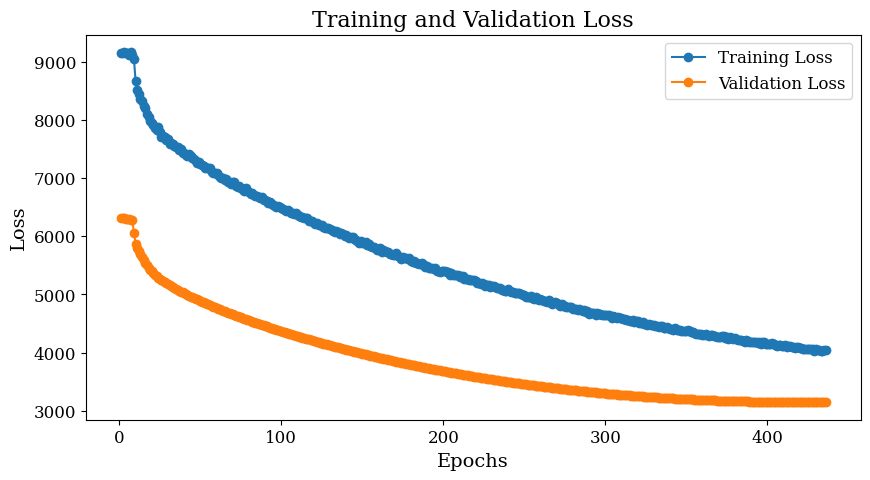

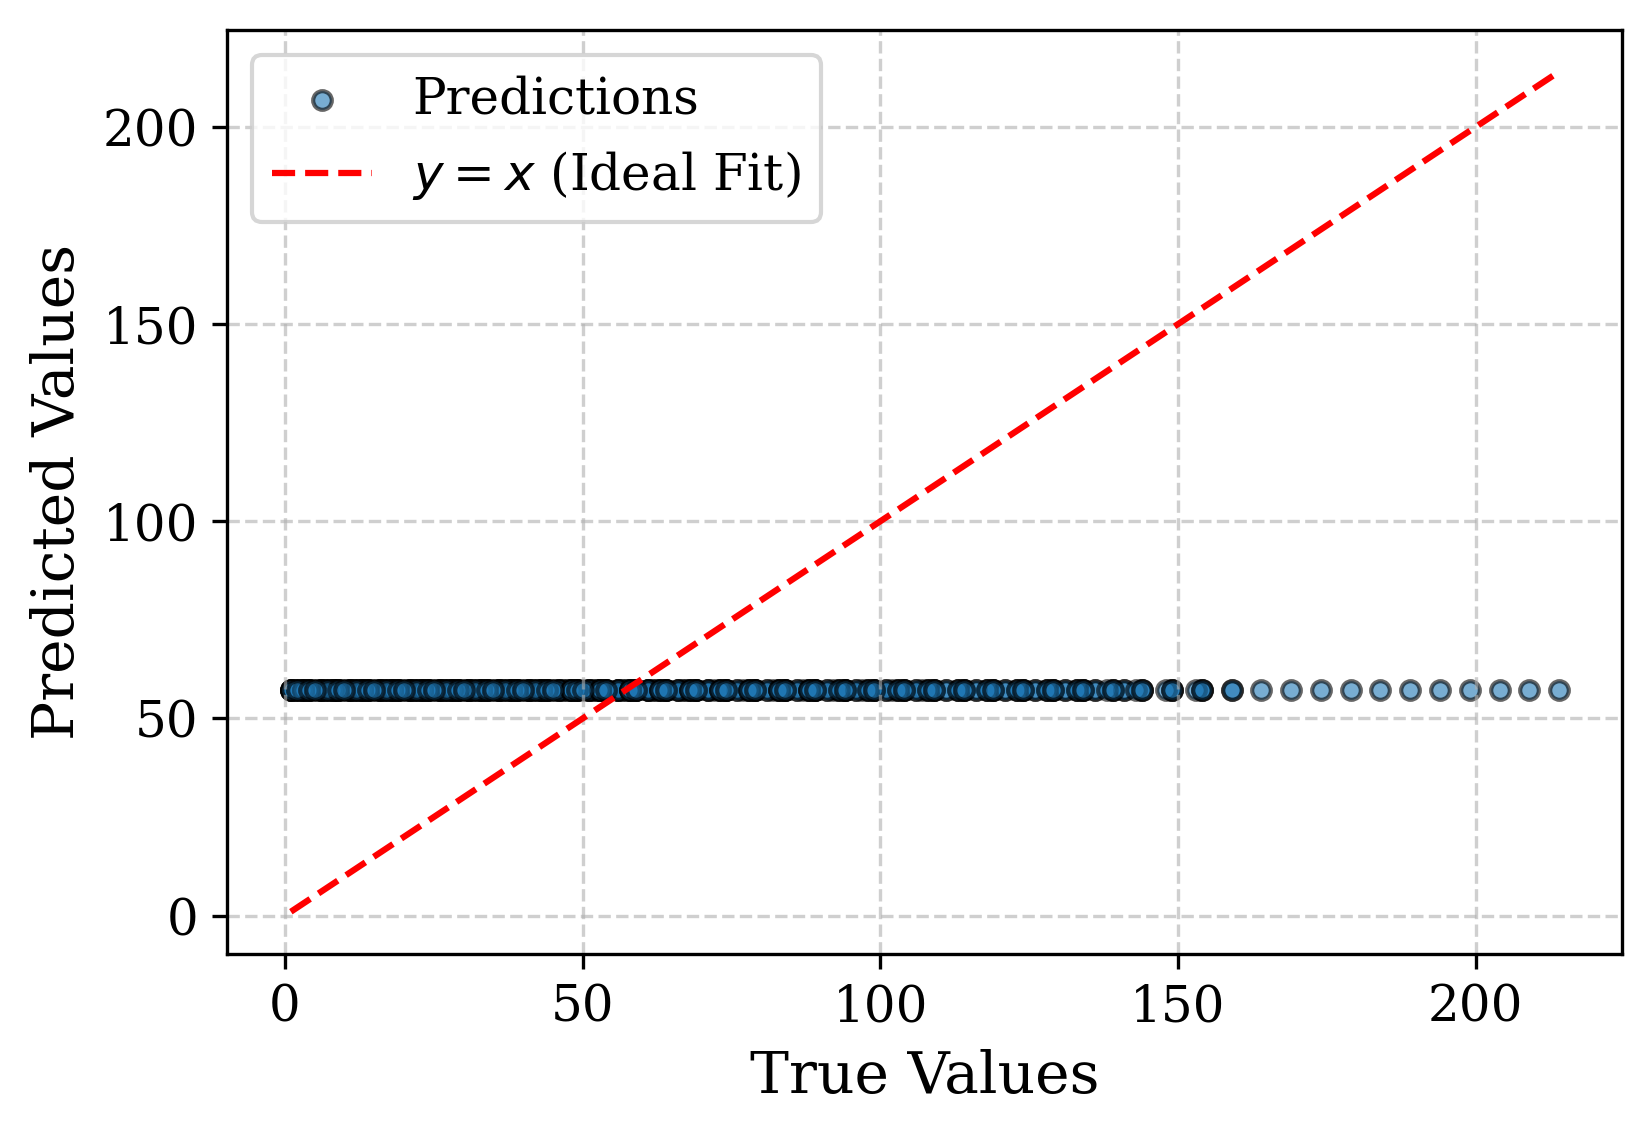

Evaluating motif 4 with size 48 and 154 indexes 
X_series shape: torch.Size([2910, 864, 2])
X_indices shape: torch.Size([2910, 14, 1])
X_mask shape: torch.Size([2910, 864])
y shape: torch.Size([2910, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 109, with best epoch being 98
Stopping early: Maximum training time exceeded.
Early stopping at epoch 466, with best epoch being 464
Early stopping at epoch 442, with best epoch being 431
Early stopping at epoch 252, with best epoch being 241
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 82, with best epoch being 71
Early stopping at epoch 82, with best epoch being 71
Early stopping at epoch 62, with best epoch being 51
Early stopping at epoch 62, with best epoch being 51
Early stopping at epoch 48, with best epoch being 37
Early stopping at epoch 96, with best epoch being 85
Early stopping at epoch 49, with best epoch being 38
Early stopping at epoch 69, with best epoch being 58
Early sto

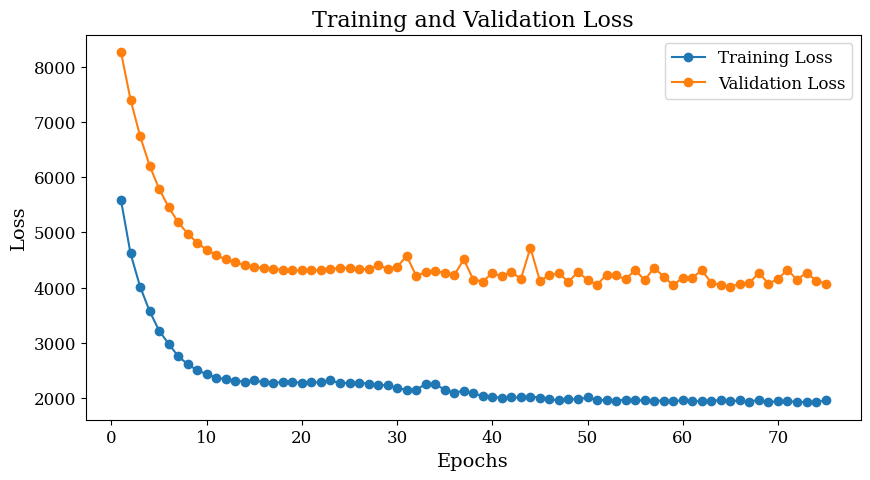

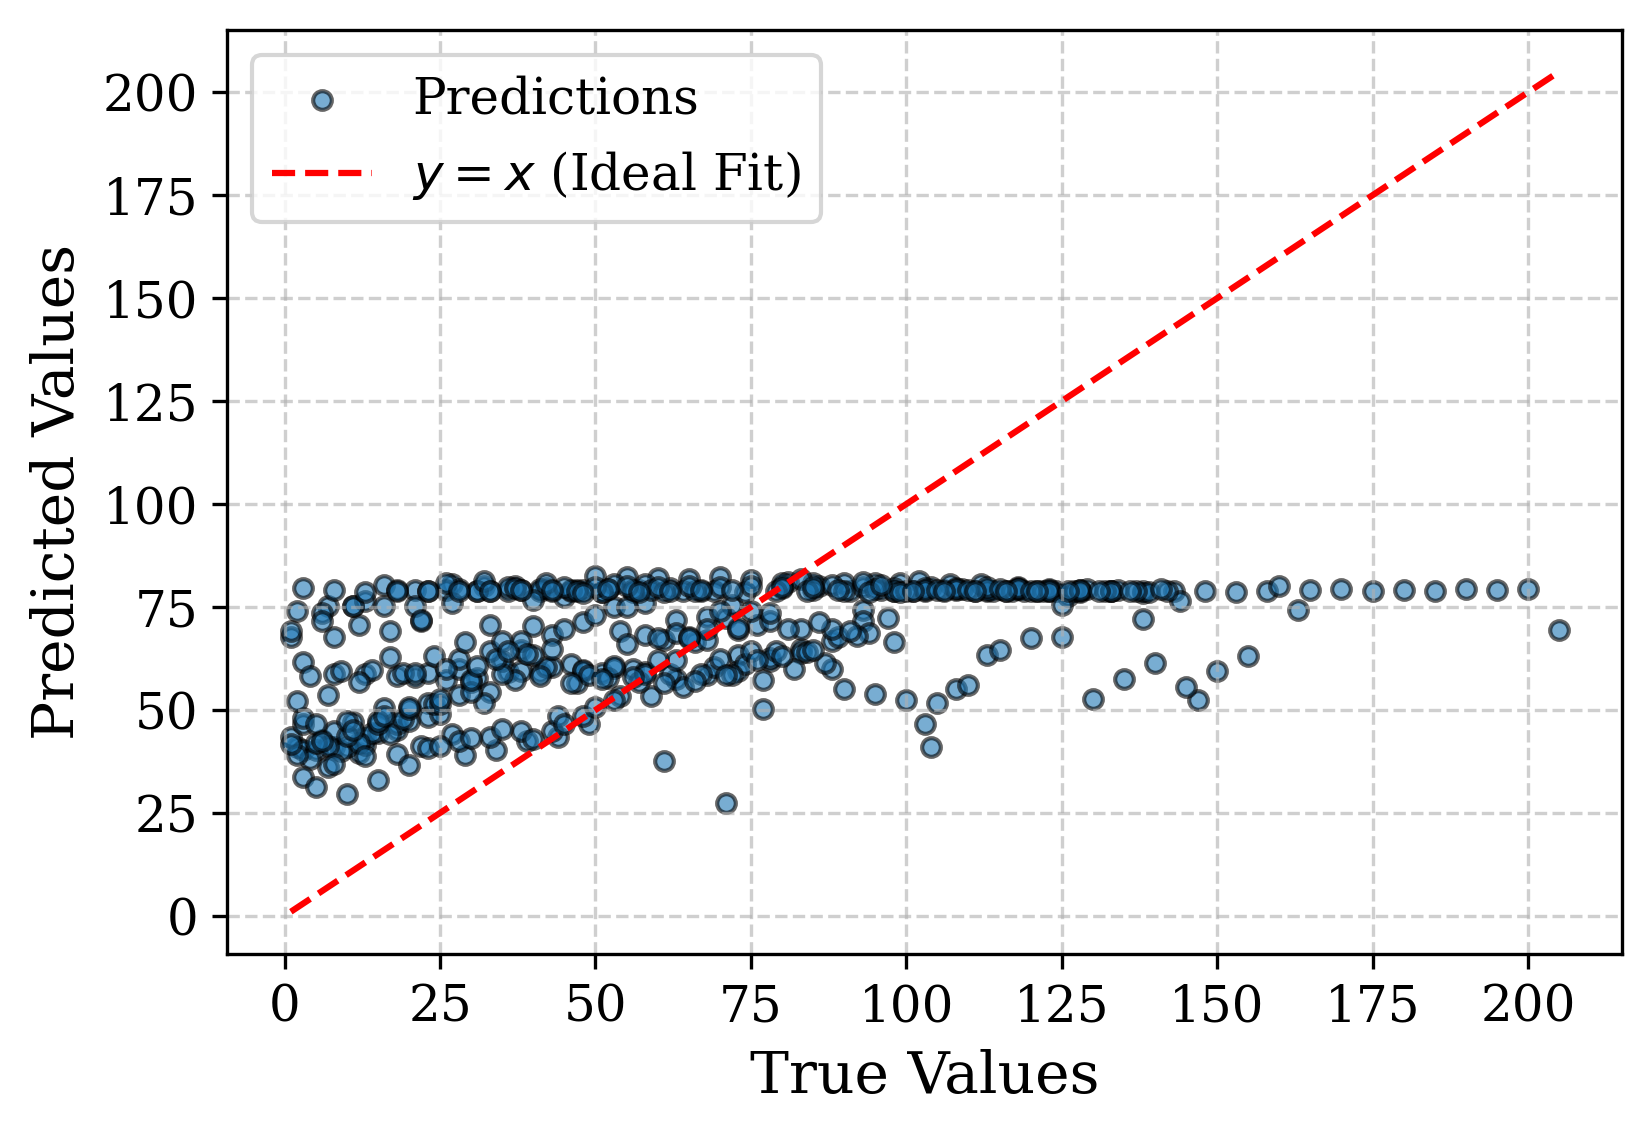

Aggregated Results Across Top 5 Motifs:
Mean Test Loss: 2748.6252685546874 ± 1561.8761053260632
Mean Test MAE: 38.47260437011719 ± 8.520050025694593
Mean Test RMSE: 50.3544204711914 ± 14.59648938637342


In [9]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.lstm_pytorch import LSTM
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test


test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():
    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i+1} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")
    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "LSTM"
    model_name = "LSTMSeries_Masking"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1,3,5]]  
        },
        "batch_size": {
            "type": "categorical",
            "args": [[16, 32, 64, 128]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_series": X_series, "X_mask": X_mask}
    run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    plot_best_model_results_traindevtest( study.trials_dataframe(),
       save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    )    
    plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")


Evaluating motif 13 with size 48 and 205 indexes 
X_series shape: torch.Size([2881, 864, 2])
X_indices shape: torch.Size([2881, 17, 1])
X_mask shape: torch.Size([2881, 864])
y shape: torch.Size([2881, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 75, with best epoch being 64
Early stopping at epoch 405, with best epoch being 394
Early stopping at epoch 356, with best epoch being 345
Early stopping at epoch 220, with best epoch being 209
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 24, with best epoch being 13
Early stopping at epoch 24, with best epoch being 13
Early stopping at epoch 24, with best epoch being 13
Early stopping at epoch 24, with best epoch being 13
Early stopping at epoch 60, with best epoch being 49
Early stopping at epoch 58, with best epoch being 47
Early stopping at epoch 38, with best epoch being 27
Early stopping at epoch 42, with best epoch being 31
Early stopping at epoch 24, with best epoch being 13
Early

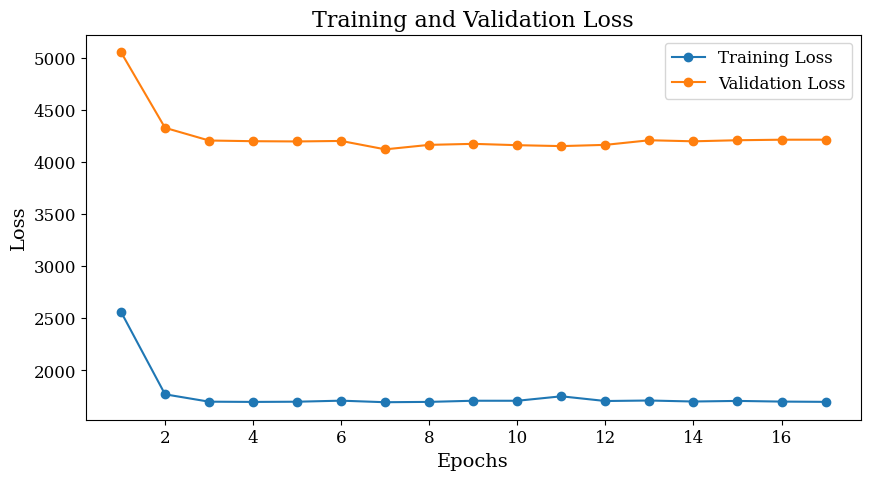

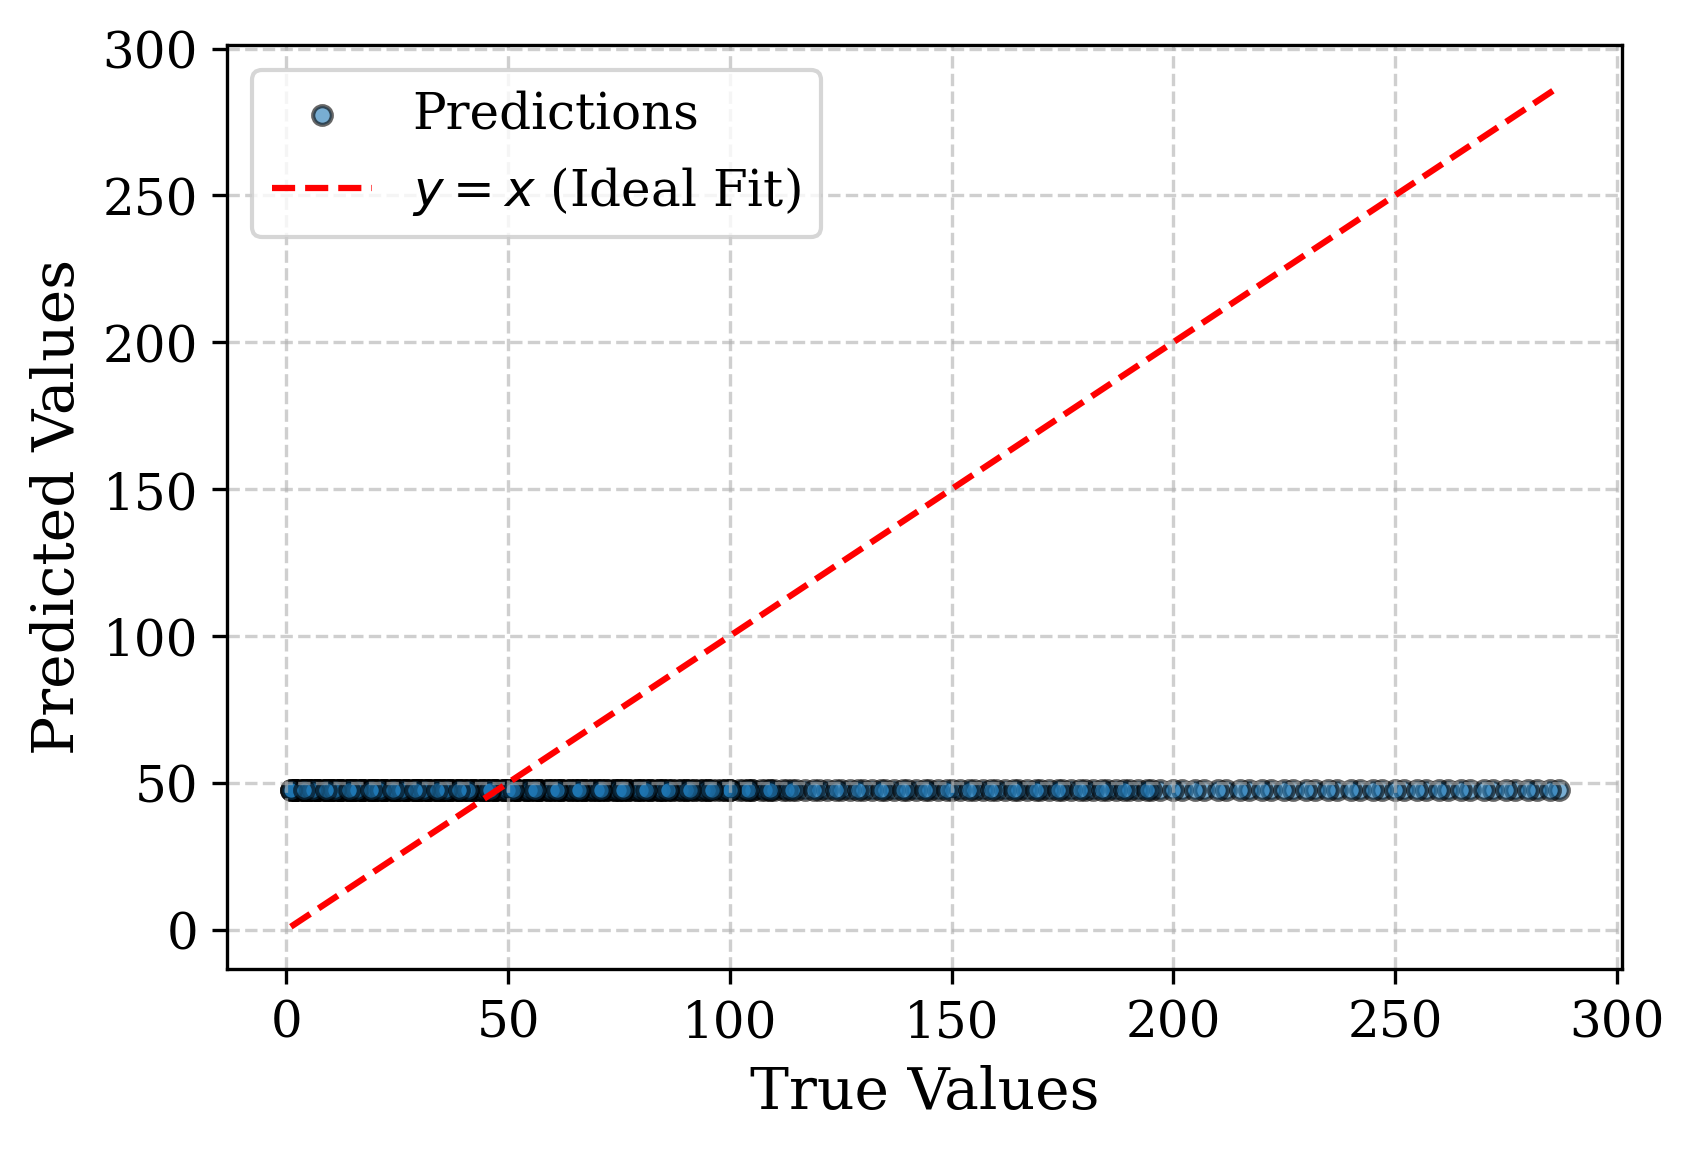

Evaluating motif 11 with size 48 and 202 indexes 
X_series shape: torch.Size([2927, 864, 2])
X_indices shape: torch.Size([2927, 17, 1])
X_mask shape: torch.Size([2927, 864])
y shape: torch.Size([2927, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 86, with best epoch being 75
Early stopping at epoch 485, with best epoch being 474
Early stopping at epoch 331, with best epoch being 320
Early stopping at epoch 305, with best epoch being 293
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 28, with best epoch being 17
Early stopping at epoch 274, with best epoch being 263
Early stopping at epoch 25, with best epoch being 12
Early stopping at epoch 179, with best epoch being 168
Early stopping at epoch 42, with best epoch being 31
Early stopping at epoch 24, with best epoch being 13
Early stopping at epoch 31, with best epoch being 20
Early stopping at epoch 24, with best epoch being 13
Early stopping at epoch 184, with best epoch being 173

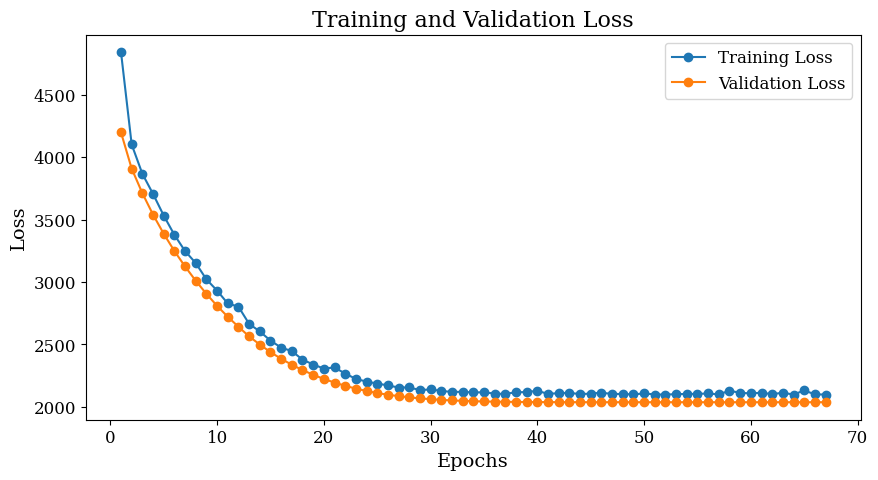

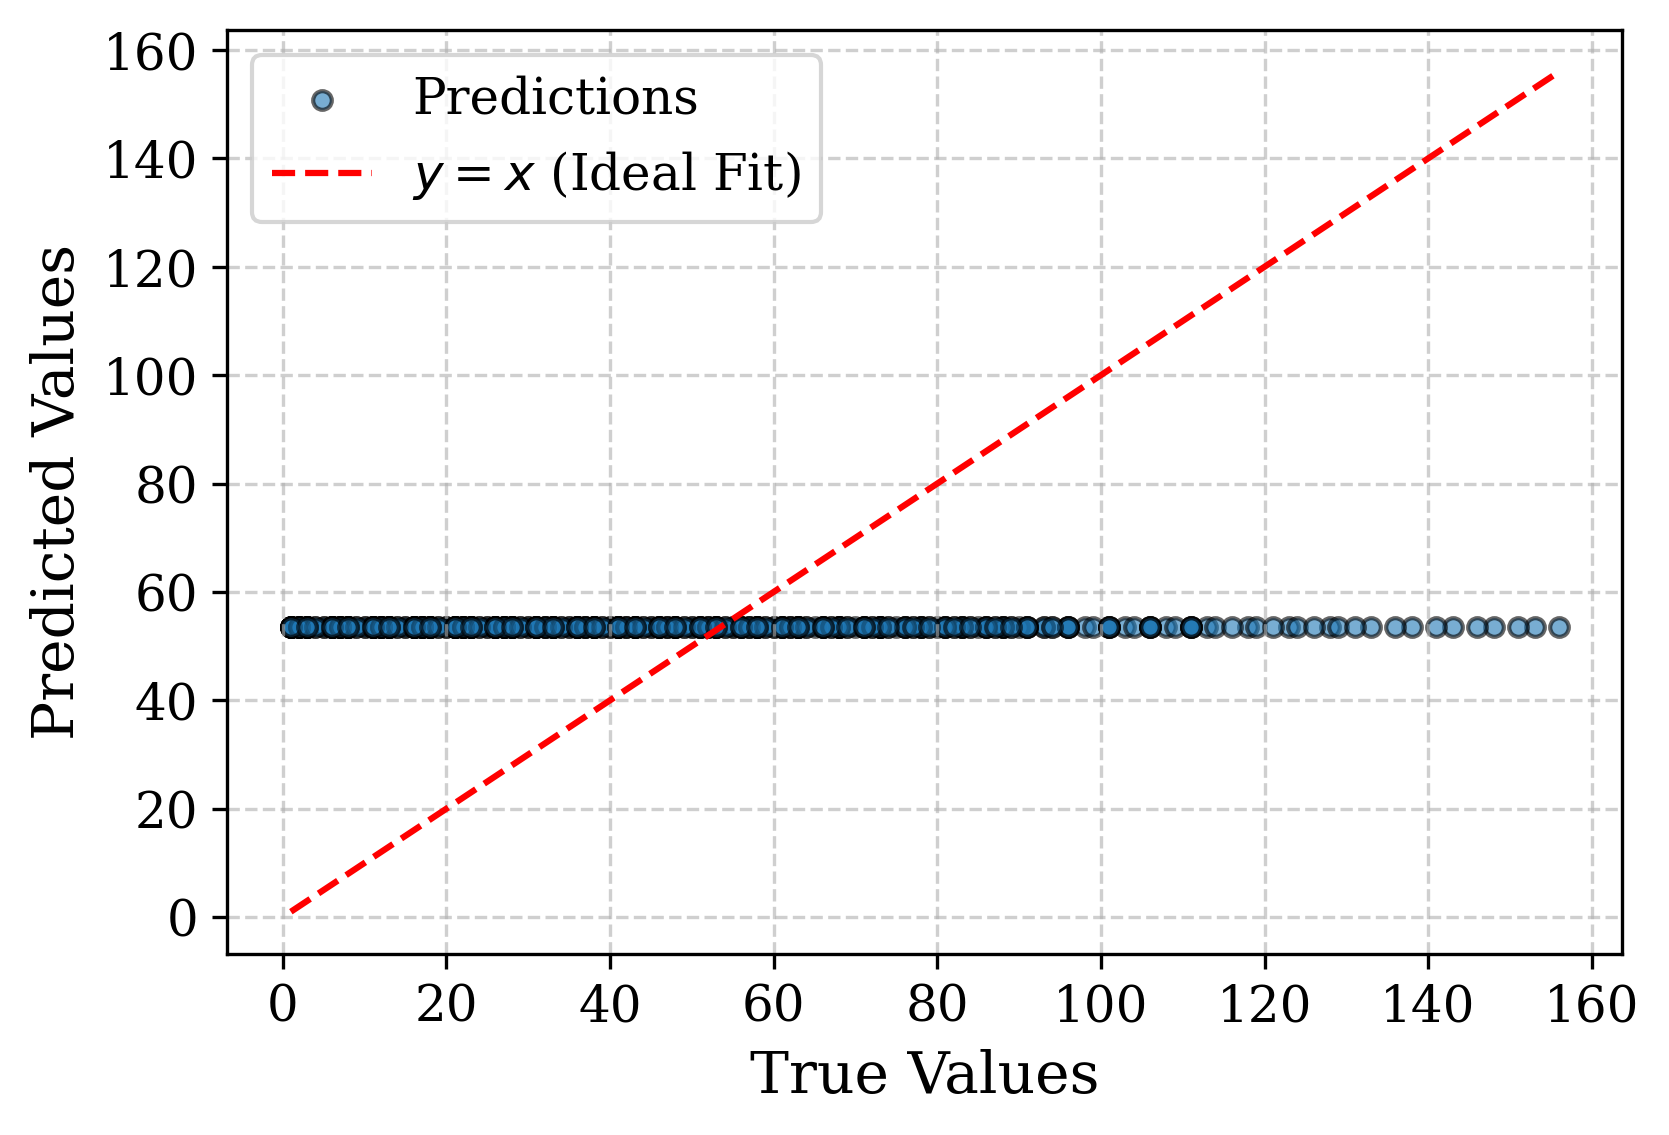

Evaluating motif 14 with size 48 and 167 indexes 
X_series shape: torch.Size([2910, 864, 2])
X_indices shape: torch.Size([2910, 15, 1])
X_mask shape: torch.Size([2910, 864])
y shape: torch.Size([2910, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 49, with best epoch being 38
Early stopping at epoch 332, with best epoch being 321
Early stopping at epoch 243, with best epoch being 232
Early stopping at epoch 197, with best epoch being 186
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 49, with best epoch being 38
Early stopping at epoch 195, with best epoch being 184
Early stopping at epoch 71, with best epoch being 60
Early stopping at epoch 42, with best epoch being 31
Early stopping at epoch 286, with best epoch being 275
Early stopping at epoch 269, with best epoch being 258
Early stopping at epoch 479, with best epoch being 468
Early stopping at epoch 38, with best epoch being 27
Early stopping at epoch 198, with best epoch being

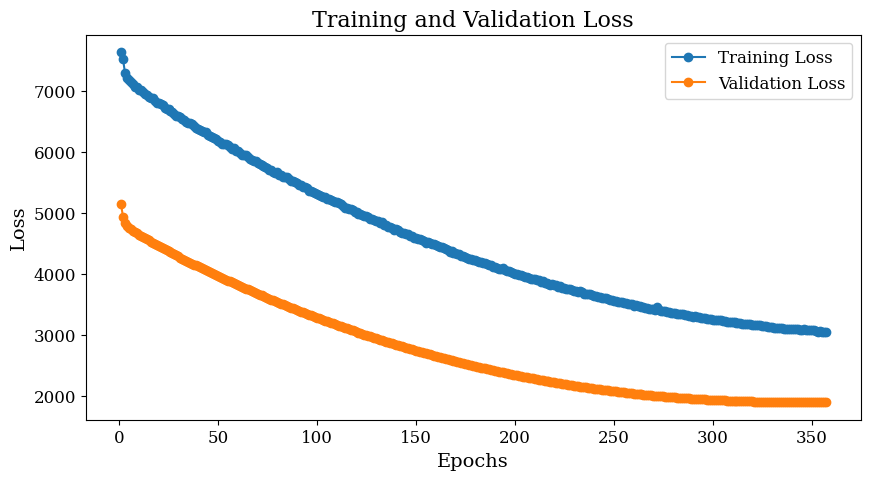

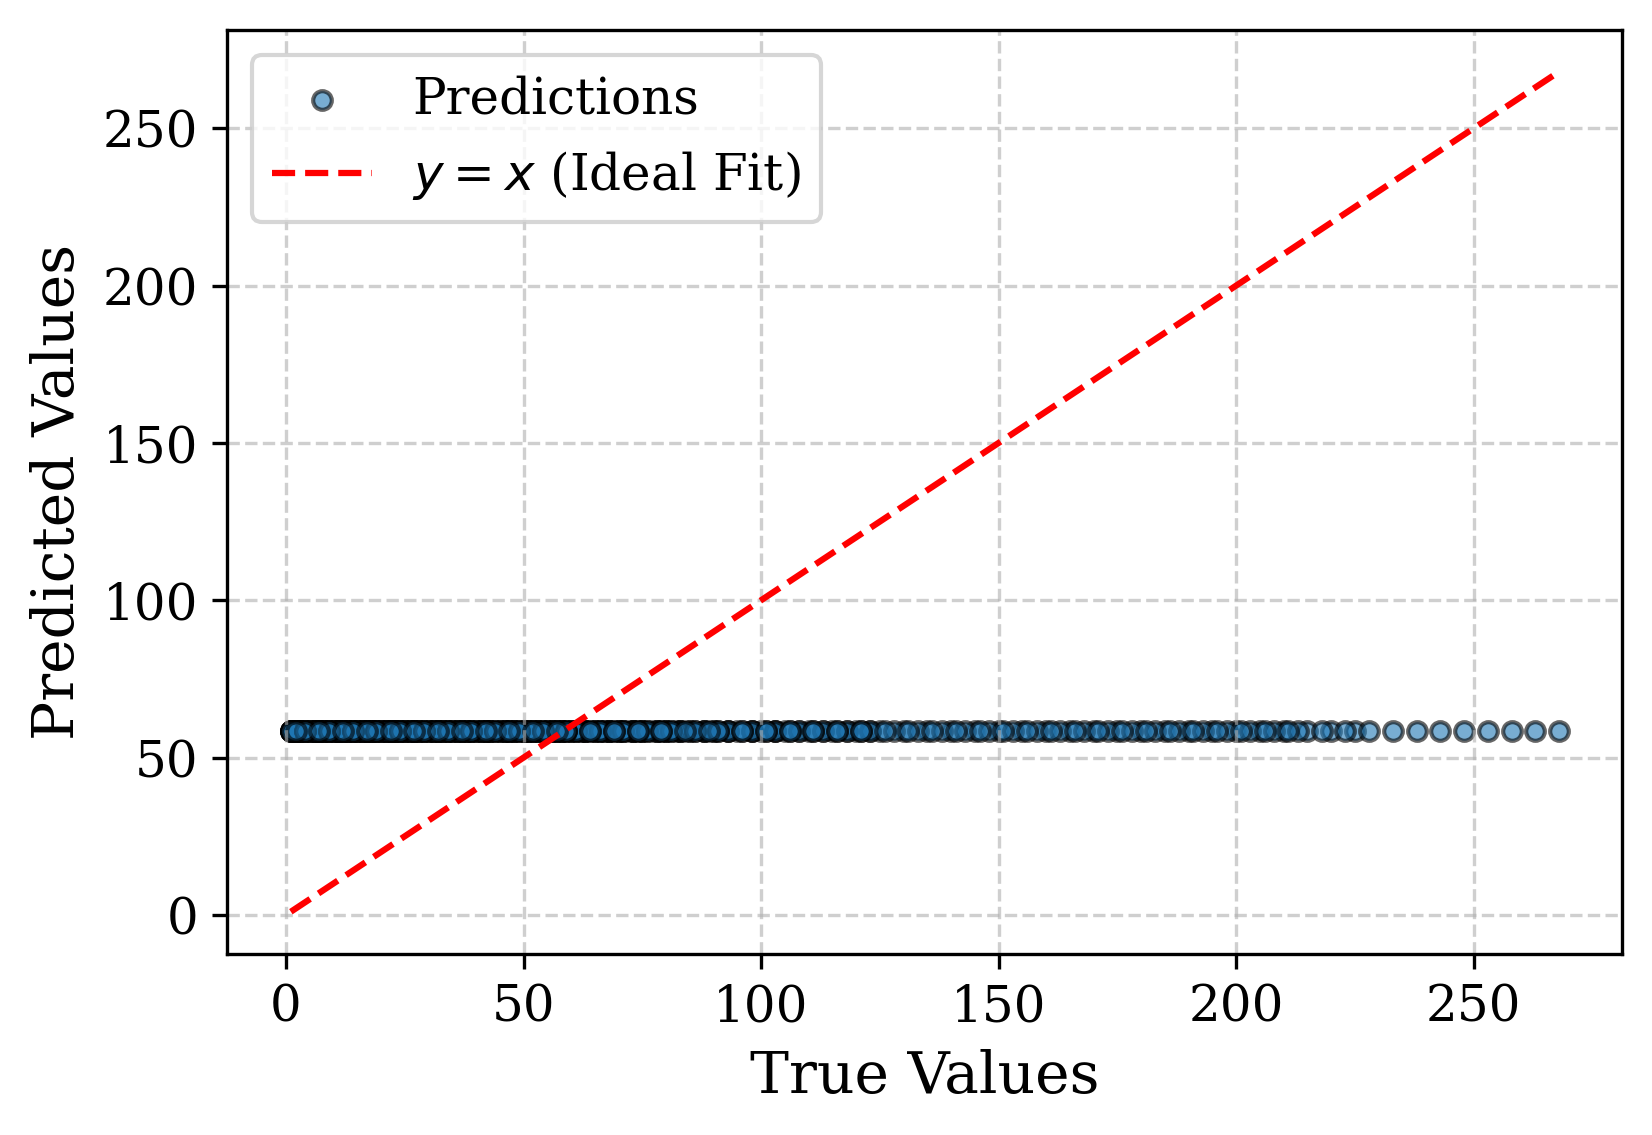

Evaluating motif 12 with size 48 and 157 indexes 
X_series shape: torch.Size([2884, 864, 2])
X_indices shape: torch.Size([2884, 15, 1])
X_mask shape: torch.Size([2884, 864])
y shape: torch.Size([2884, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 46, with best epoch being 35
Early stopping at epoch 322, with best epoch being 310
Early stopping at epoch 228, with best epoch being 217
Early stopping at epoch 191, with best epoch being 180
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 20, with best epoch being 9
Early stopping at epoch 63, with best epoch being 52
Early stopping at epoch 392, with best epoch being 381
Early stopping at epoch 80, with best epoch being 69
Early stopping at epoch 66, with best epoch being 55
Early stopping at epoch 28, with best epoch being 17
Early stopping at epoch 94, with best epoch being 83
Early stopping at epoch 351, with best epoch being 340
Early stopping at epoch 41, with best epoch being 30
Ea

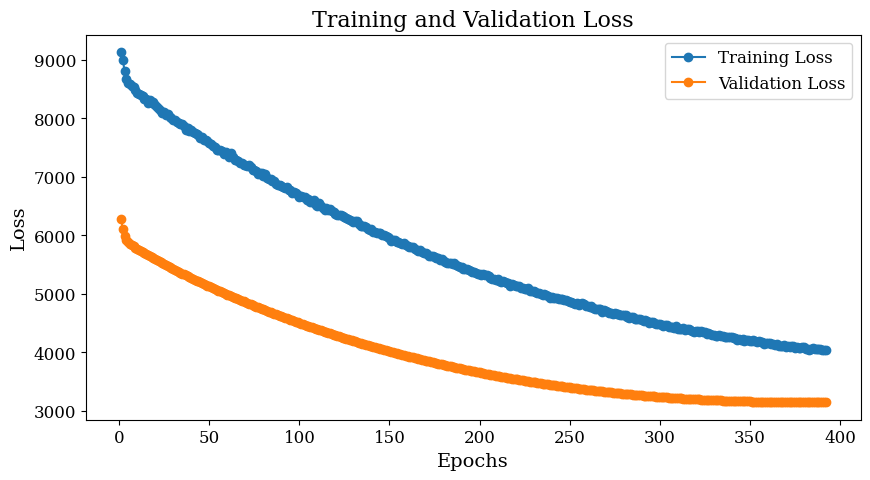

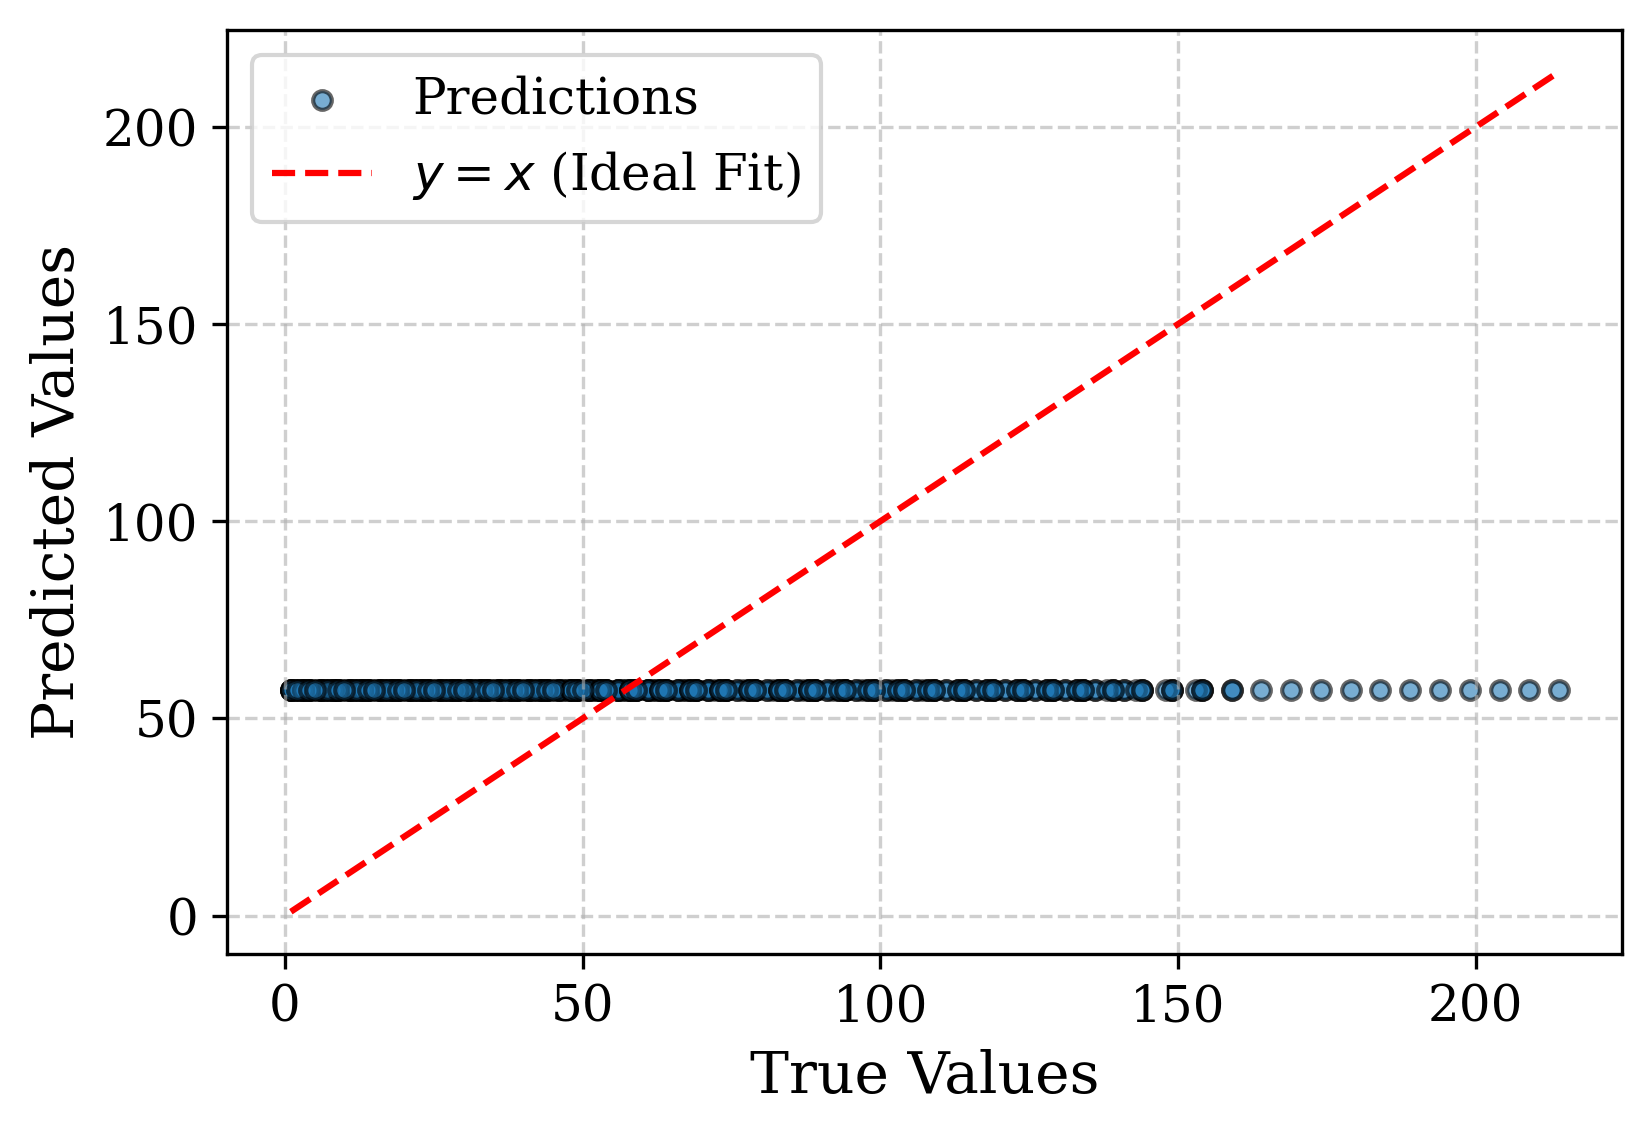

Evaluating motif 4 with size 48 and 154 indexes 
X_series shape: torch.Size([2910, 864, 2])
X_indices shape: torch.Size([2910, 14, 1])
X_mask shape: torch.Size([2910, 864])
y shape: torch.Size([2910, 1])


  0%|          | 0/100 [00:00<?, ?it/s]

Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 94, with best epoch being 83
Training completed all epochs. Best epoch was 496
Early stopping at epoch 452, with best epoch being 441
Early stopping at epoch 409, with best epoch being 398
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 32, with best epoch being 21
Early stopping at epoch 32, with best epoch being 21
Early stopping at epoch 32, with best epoch being 21
Early stopping at epoch 32, with best epoch being 21
Early stopping at epoch 66, with best epoch being 55
Early stopping at epoch 52, with best epoch being 41
Early stopping at epoch 77, with best epoch being 66
Early stopping at epoch 32, with best epoch being 21
Early stopping at epoch 16, with best epoch being 5
Early stopp

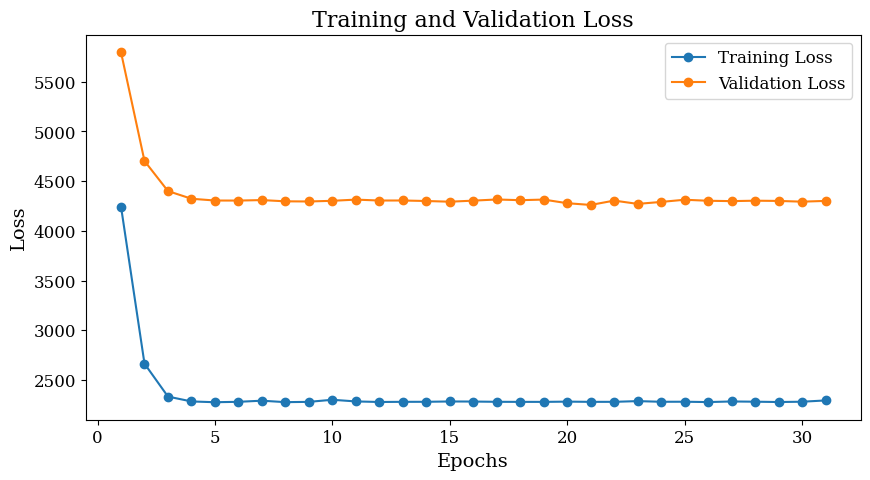

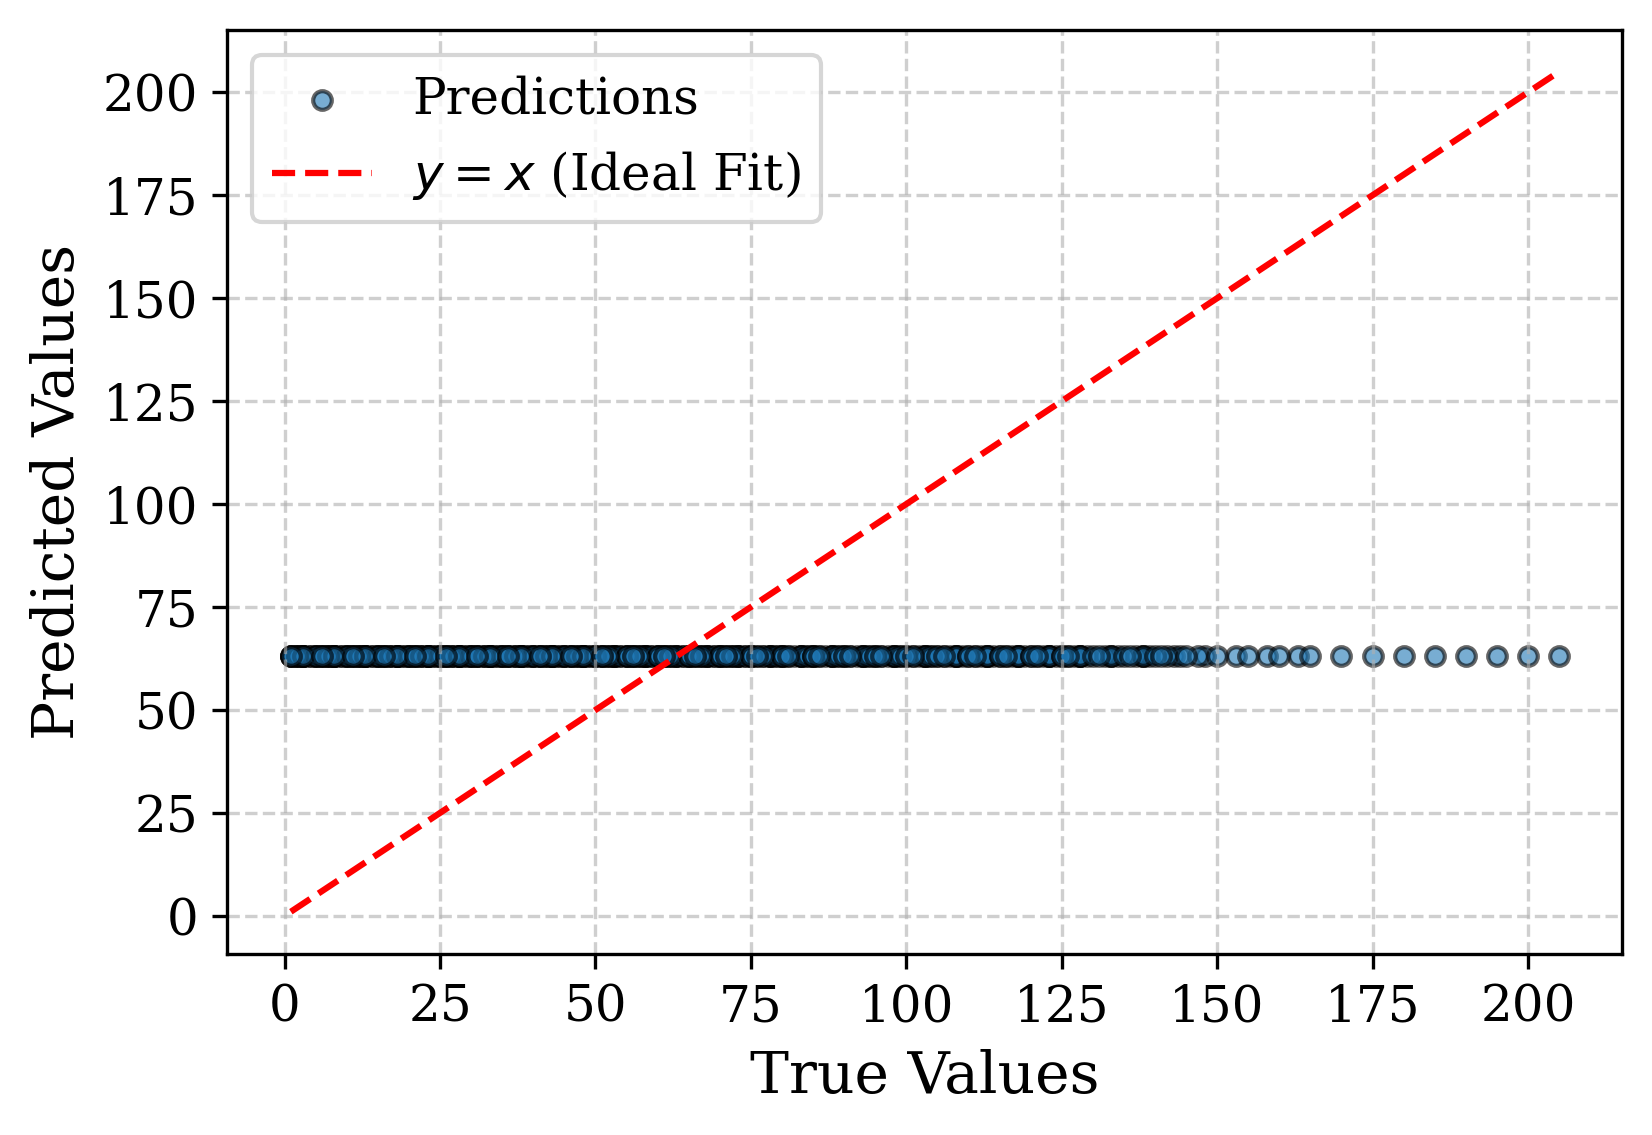

Aggregated Results Across Top 5 Motifs:
Mean Test Loss: 2865.8638671875 ± 1492.1893823811313
Mean Test MAE: 39.352334594726564 ± 6.9829224149860325
Mean Test RMSE: 51.78831405639649 ± 13.558553332546461


In [8]:
from utils.utils import create_dataset
from utils.train_pipeline import run_optuna_study
from utils.utils import get_best_model_results_traindevtest, plot_best_model_results_traindevtest
from models.lstm_pytorch import LSTM
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config_train_val_test

test_losses_list = []
test_mae_list = []
test_rmse_list = []

# Loop through each of the top 10 motifs
for i, top_motif in top_motifs.iterrows():
    motif_indexes = sorted(ast.literal_eval(top_motif["Indices"]))
    
    print(f"Evaluating motif {i+1} with size {MOTIF_SIZE} and {len(motif_indexes)} indexes ")

    
    # Create dataset for the current motif
    X_series, X_indices, X_mask, y = create_dataset(data, LOOKBACK_PERIOD, STEP, FORECAST_PERIOD, motif_indexes, MOTIF_SIZE)

    # X_series, X2, and y are now PyTorch tensors
    print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, LOOKBACK_PERIOD, num_features)
    print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
    print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
    print("y shape:", y.shape)    # Expected shape: (num_samples, 1)
    
    # Define the model and run the Optuna study
    n_trials = 100
    num_epochs = 500
    model_type = "LSTM"
    model_name = "LSTMIndexes"

    suggestion_dict = {
        "learning_rate": {
            "type": "float",
            "args": [1e-5, 1e-3], 
            "kwargs": {"log": True} 
        },
        "num_layers": {
            "type": "categorical",
            "args": [[1,3,5]]  
        },
        "batch_size": {
            "type": "categorical",
            "args": [[16, 32, 64, 128]]
        }
    }

    model_params_keys = ["hidden_sizes_list"]
    model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}")
    os.makedirs(model_results_dir, exist_ok=True)  

    X = {"X_indices": X_indices}
    run_optuna_study(pipeline.run_train_val_test, eval(model_type), model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

    study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
    train_losses, val_losses, best_epoch, test_loss, test_mae, test_rmse = get_best_model_results_traindevtest(study)

    print(f"Best epoch: {best_epoch}")
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

    test_losses_list.append(test_loss)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    
    # Plot predictions vs true values
    epochs_train_losses, epochs_val_losses, val_losses, test_losses, test_mae, test_rmse, all_predictions, all_true_values = get_preds_best_config_train_val_test(study, pipeline, eval(model_type), model_type, model_params_keys, num_epochs=num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)
    plot_best_model_results_traindevtest( study.trials_dataframe(),
       save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_best_results.png")
    )    
    plot_preds_vs_truevalues(np.ravel(all_true_values), np.ravel(all_predictions), fold=0, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_motif_{i+1}_fold_{0}_predictions.png"))


# Convert lists to numpy arrays for easier calculations
test_losses_array = np.array(test_losses_list)
test_mae_array = np.array(test_mae_list)
test_rmse_array = np.array(test_rmse_list)

# Calculate mean and standard deviation
mean_test_loss = np.mean(test_losses_array)
std_test_loss = np.std(test_losses_array)

mean_test_mae = np.mean(test_mae_array)
std_test_mae = np.std(test_mae_array)

mean_test_rmse = np.mean(test_rmse_array)
std_test_rmse = np.std(test_rmse_array)

# Print aggregated results
print(f"Aggregated Results Across Top 5 Motifs:")
print(f"Mean Test Loss: {mean_test_loss} ± {std_test_loss}")
print(f"Mean Test MAE: {mean_test_mae} ± {std_test_mae}")
print(f"Mean Test RMSE: {mean_test_rmse} ± {std_test_rmse}")
